/tmp/ipykernel_88943/4078025254.py:34: UserWarning: Warning: converting a masked element to nan.
  mags = np.array([


Epoch 1: loading weights from /data/kirg/MMVAE/epochs/BandPassVAE/weights_epoch_01.weights.h5
(129135, 5) (129135, 32)


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_547']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_547']
Received: inputs=Tensor(shape=(129135, 5))
  warnings.warn(msg)


ValueError: Dimension mismatch between samples and range

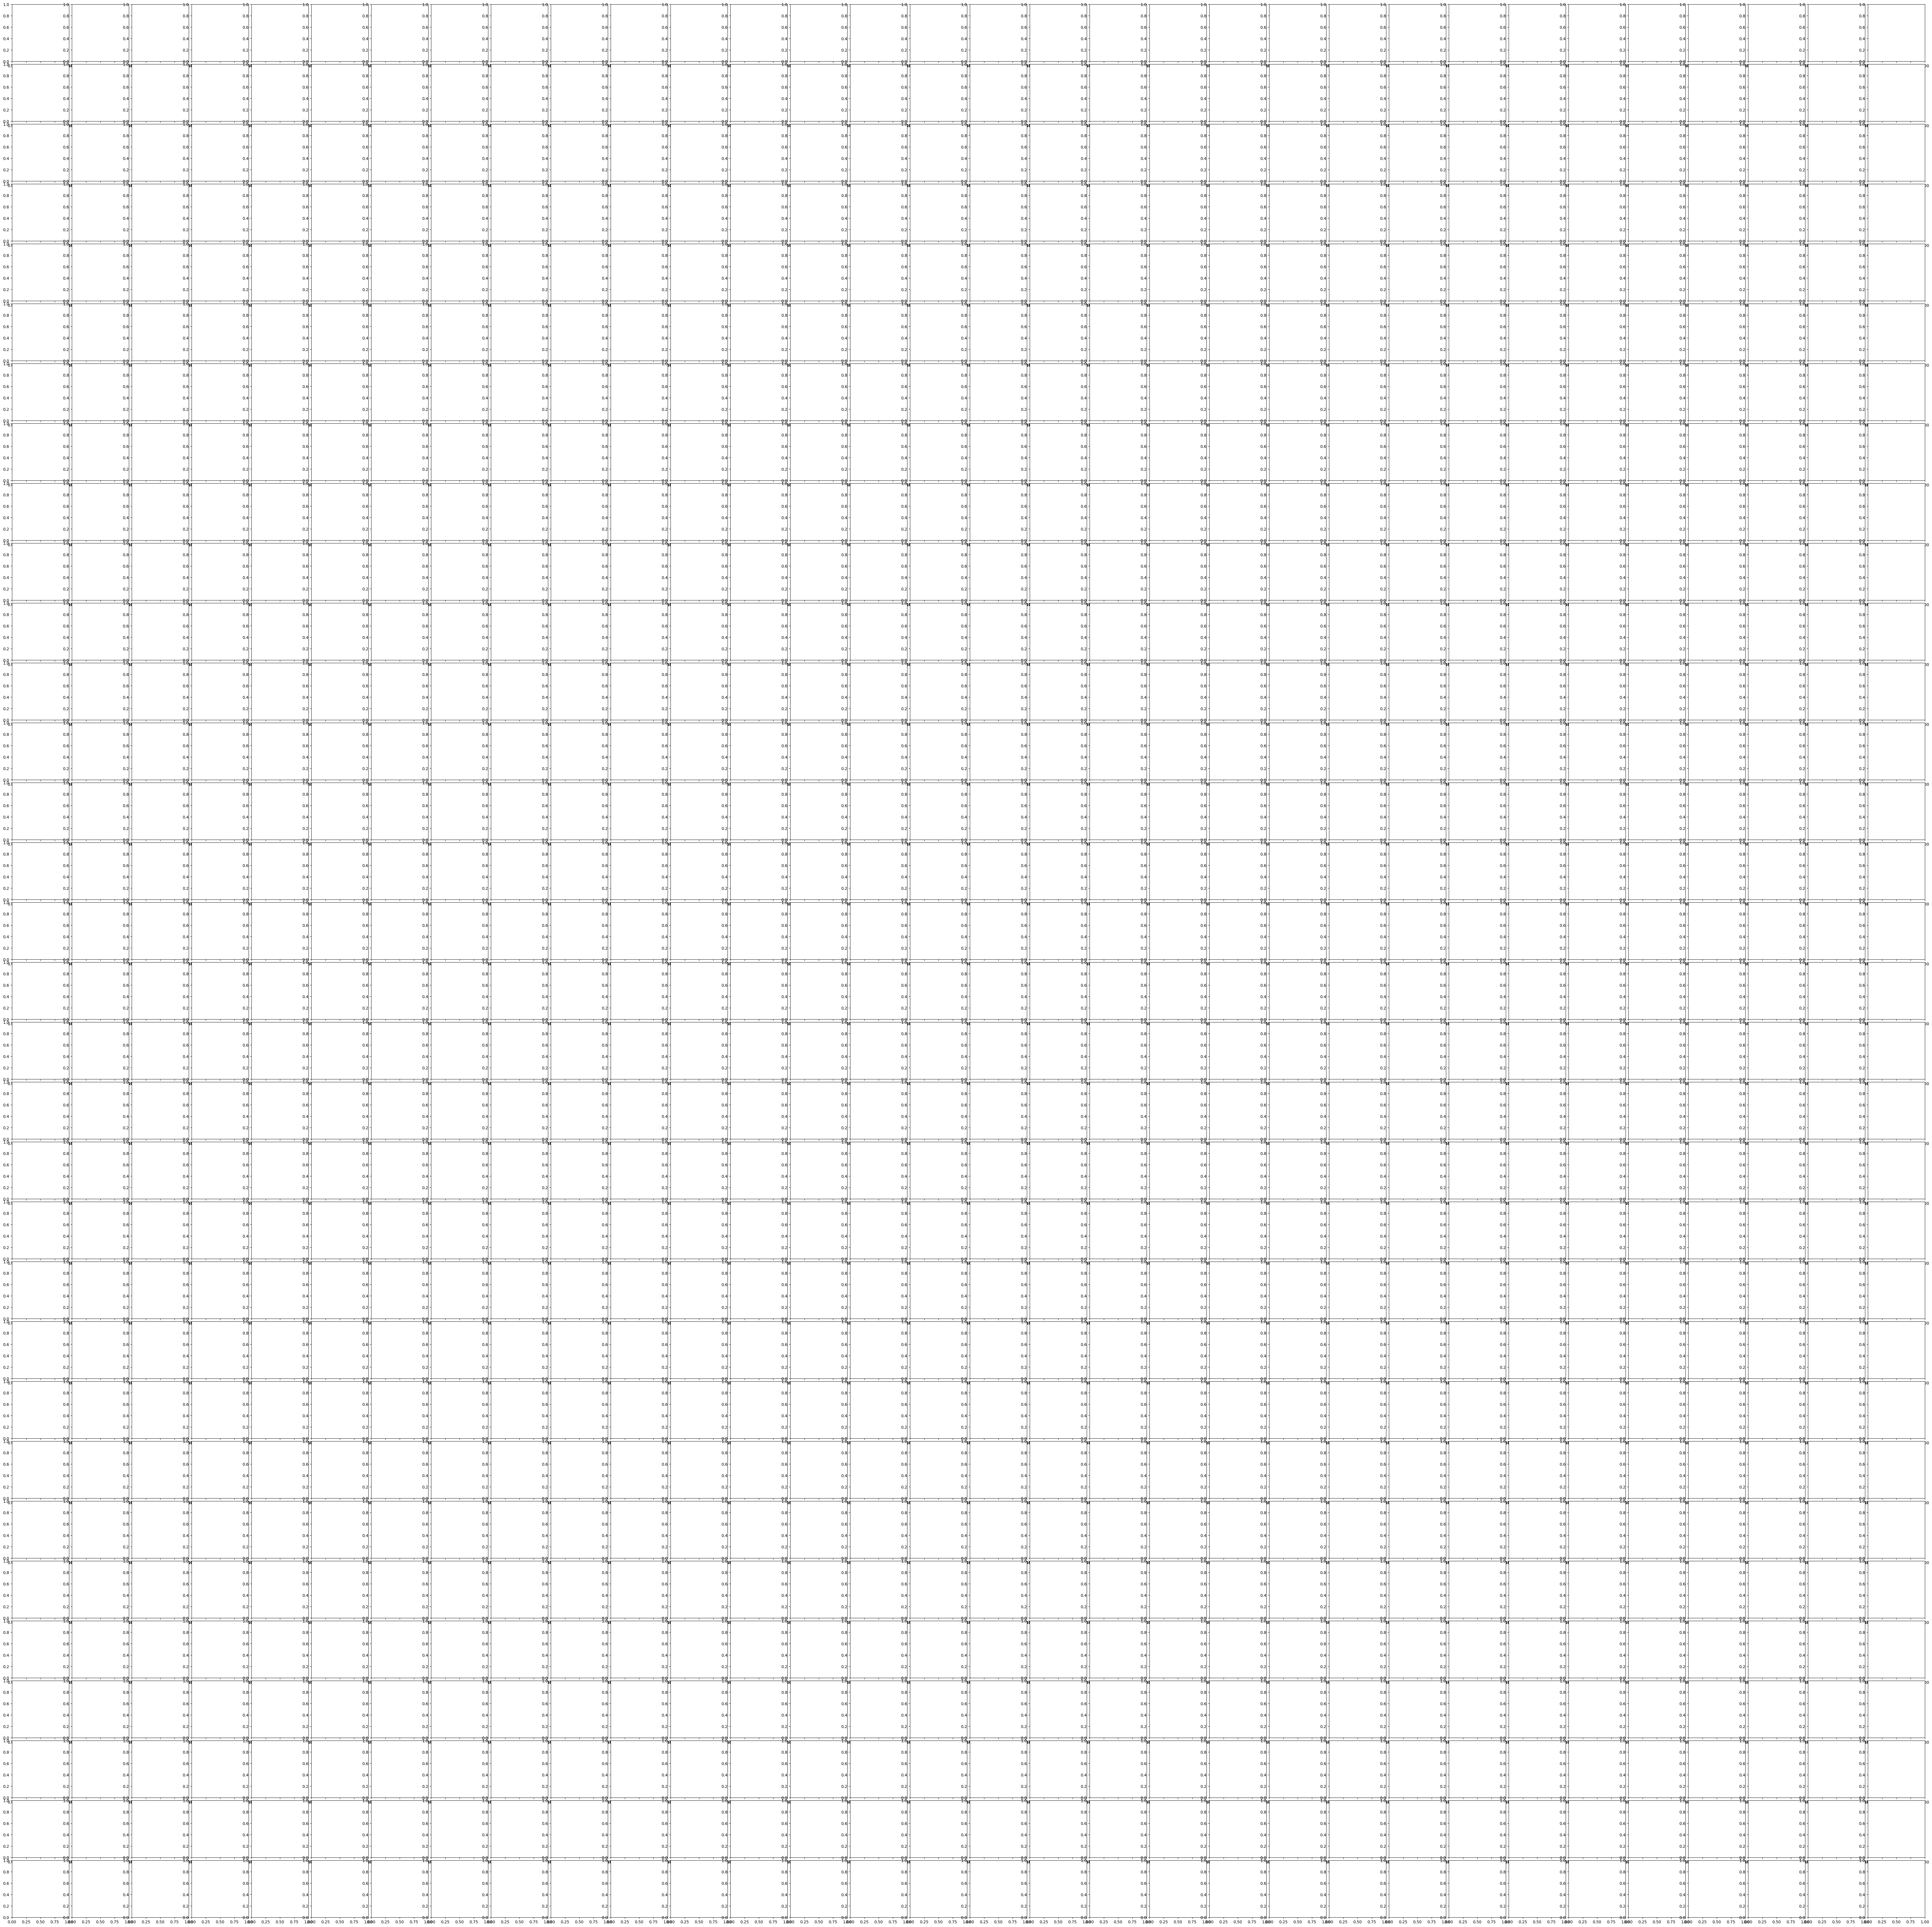

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import corner
from astropy.io import fits
from astropy.table import Table
from ParamVAEapply import ParamVAEapply
from BandPassVAE import BandPassVAE
from SpectraVAE import SpectraVAE
from ParamVAE import ParamVAE
import tensorflow as tf
import keras

# Configuration
latent_dim = 32
beta = 1e-3
epochs = 50
input_dim = 5  # Number of input bands

# Paths
weight_path = "/data/kirg/MMVAE/"
save_path = os.path.join(weight_path, 'epochs/BandPassVAE/')
plot_output_path = os.path.join(weight_path, 'cornerplots')
os.makedirs(plot_output_path, exist_ok=True)

# Load photometric data from FITS file
fits_file = 'DESI_DR1_HSCSSP_clean_v2.fits'
t_hsc_ = Table.read(fits_file)
t_hsc = t_hsc_[(t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0)]

# Convert magnitudes to normalized fluxes
hsc_int = []
for row in t_hsc:
    mags = np.array([
        row['g_kronflux_mag'],
        row['r_kronflux_mag'],
        row['i_kronflux_mag'],
        row['z_kronflux_mag'],
        row['y_kronflux_mag']
    ])
    band_flux = 10**(-0.4 * mags)
    band_flux /= np.max(band_flux)
    hsc_int.append(band_flux)

hsc_input = np.reshape(hsc_int, (len(hsc_int), input_dim))

# Loop through all epochs
for epoch in range(1, epochs + 1):
    weight_file = os.path.join(save_path, f'weights_epoch_{epoch:02d}.weights.h5')
    
    if not os.path.exists(weight_file):
        print(f"Skipping epoch {epoch}: weights not found.")
        continue

    print(f"Epoch {epoch}: loading weights from {weight_file}")

    # Rebuild models
    spvae = SpectraVAE(100, latent_dim, beta=beta)  # dummy spectra input size
    bpvae = BandPassVAE(input_dim, latent_dim, spvae, beta=beta)
    bpvae.compile(optimizer=keras.optimizers.Adam())
    bpvae(tf.zeros((1, input_dim)))  # Build model

    # Load weights
    try:
        bpvae.load_weights(weight_file)
    except Exception as e:
        print(f"Error loading weights for epoch {epoch}: {e}")
        continue

    # Create ParamVAE and ParamVAEapply
    parvae = ParamVAE(input_dim, latent_dim, spvae, beta=beta)
    parvaeapply = ParamVAEapply(input_dim, latent_dim, bpvae, parvae, beta=beta)

    # Apply model to input data
    s = np.array(parvaeapply.encoder(hsc_input))
    print(hsc_input.shape, s[0, :, :].shape)
    # Plot corner plot of first few latent dimensions
    fig = corner.corner(
        s[0, :, :],
        #labels=[f"$z_{i}$" for i in range(latent_dim)],
        #show_titles=True,
        title_fmt=".2f",
        title_kwargs={"fontsize": 12},
        range=[-1, 1]
    )

    filename = os.path.join(plot_output_path, f"corner_epoch_{epoch:02d}.png")
    fig.savefig(filename)
    plt.close(fig)

    print(f"Saved: {filename}")
